# PhyParts PieCharts

## *Making sense of gene tree conflict*


The goal of this notebook is to recreate figures like this one from Smith et al. 2015, which visualize the amount of gene tree conflict on a species phylogeny using pie charts:

![smith_pies](https://static-content.springer.com/image/art%3A10.1186%2Fs12862-015-0423-0/MediaObjects/12862_2015_423_Fig2_HTML.gif)

In the figure above, the pie charts represent the proportion of gene trees that:

* Blue: Support the shown topology
* Green: Conflict with the shown topology (most common conflicting bipartion)
* Red: Conflict with the shown topology (all other supported conflicting bipartitions)
* Gray: Have no support for conflicting bipartion

When evaluating gene tree support for a species topology, it is important to consider the ratio of blue to green on the pie chart. A high green proportion means there is a dominant alternative topology which should be considered. A very small sliver of blue is also indicative of low overall support for the shown topology. In many cases, bootstrap values may be near 100% for this node, despite the lack of support in any one gene tree.

In the paper the authors describe a package (written in Java) called Phyparts: https://bitbucket.org/blackrim/phyparts

The input to Phyparts is a rooted species phylogeny and a directory containing rooted gene trees. For every bipartition (leaves descending from each side of a bifurcating branch) on the species phylogeny, Phyparts sorts the gene trees into categories based on whether the gene tree is concordant with the species tree or is conflictint with the species tree. Phyparts outputs several files describing the levels of concordance and conflict, and identifies each conflicting bipartition and its frequency.

In this notebook we will use the lessons from the BakingPieCharts notebook to use the output of PhyParts to draw the pie charts using ETE3 in Python.


###### Citation: Smith SA, Moore MJ, Brown JW, and Yang, Y. 2015. "Analysis of phylogenomic datasets reveals conflict, concordance, and gene duplications with examples from animals and plants." BMC Evol. Bio. 15:150. DOI: 10.116/s12862-015-0423-0

In [1]:
%matplotlib inline
from ete3 import Tree, TreeStyle, TextFace,NodeStyle,faces, COLOR_SCHEMES

Set the location of the input files. In this case, we're using rooted gene trees with branches collapsed if they had less than 30% gene tree bootstrap support. 

In [2]:
#Species Tree
sptree_file = "aa/moss_backone_aa_astral_collapsed_rerooted.tre"

#Phyparts Output Files
histfile = "aa/phyparts_aa_astral_collapsed.hist"
keyfile = "aa/phyparts_aa_astral_collapsed.node.key"
concon_treefile = "aa/phyparts_aa_astral_collapsed.concon.tre"
total_genes = 96

Load the species tree into ETE3

In [3]:
sptree = Tree(sptree_file)

Associate the nodes labeled by PhyParts with nodes on the ETE3 species tree.

In [4]:
phyparts_node_key = [line for line in open(keyfile)]
subtrees_dict = {n.split()[0]:Tree(n.split()[1]+";") for n in phyparts_node_key}
subtrees_topids = {}
for x in subtrees_dict:
    subtrees_topids[x] = subtrees_dict[x].get_topology_id()

for node in sptree.traverse():
    node_topid = node.get_topology_id()
    for subtree in subtrees_dict:
        if node_topid == subtrees_topids[subtree]:
            node.name = subtree


Associate the number of concordant and conflicting bipartitions with each node, using the tree file generated by PhyParts. The first tree has the number of concordant gene trees as branch labels, and the second tree has the number of conflicting gene trees as branch labels.

Since ETE3 always traverses the same topology in the same order, these will be the same nodes as the species tree.

In [5]:
with open(concon_treefile) as phyparts_trees:
    concon_tree = Tree(phyparts_trees.readline())
    conflict_tree = Tree(phyparts_trees.readline())

concord_dict = {}
conflict_dict = {}


for node in concon_tree.traverse():
    node_topid = node.get_topology_id()
    for subtree in subtrees_dict:
        if node_topid == subtrees_topids[subtree]:
            concord_dict[subtree] = node.support
    
for node in conflict_tree.traverse():
    node_topid = node.get_topology_id()
    for subtree in subtrees_dict:
        if node_topid == subtrees_topids[subtree]:
            conflict_dict[subtree] = node.support    
    

Generate the Pie chart data using the "hist" file and the number of concordant and conflicting gene trees. Pie charts are proportions out of the total number trees as set above, with these values:

* Proportion concordant
* Proportion conflicting (most frequent conflicting bipartition)
* Proportion conflicting (all other supported conflicting bipartitions)
* The rest

In [6]:



#Node,concord,conflict1,conflict2,totConcord&Conflict

phyparts_hist = [line for line in open(histfile)]

phyparts_pies = {}

phyparts_dict = {}


for n in phyparts_hist:
    n = n.split(",")
    tot_genes = float(n.pop(-1))
    node_name = n.pop(0)[4:]
    concord = float(n.pop(0))
    concord = concord_dict[node_name]
    
    if len(n) > 0:   
        most_conflict = max([float(x) for x in n])
    else:
        most_conflict = 0.0
    
    adj_concord = concord/total_genes * 100 
    adj_most_conflict = most_conflict/total_genes * 100
    other_conflict = (tot_genes - concord - most_conflict) / total_genes * 100
    the_rest = (total_genes - adj_concord - adj_most_conflict - other_conflict) / total_genes * 100
    
    phyparts_pies[node_name] = [adj_concord,adj_most_conflict,other_conflict,the_rest]
    
    phyparts_dict[node_name] = [int(round(concord,0)),int(round(tot_genes-concord,0))]

    
#print phyparts_pies    
            


Define the Piecharts layout Face, using the same colors as the Smith et al. paper in the pies.

The raw number of concordant and conflicting gene trees is also shown above and below the branches, respectively.

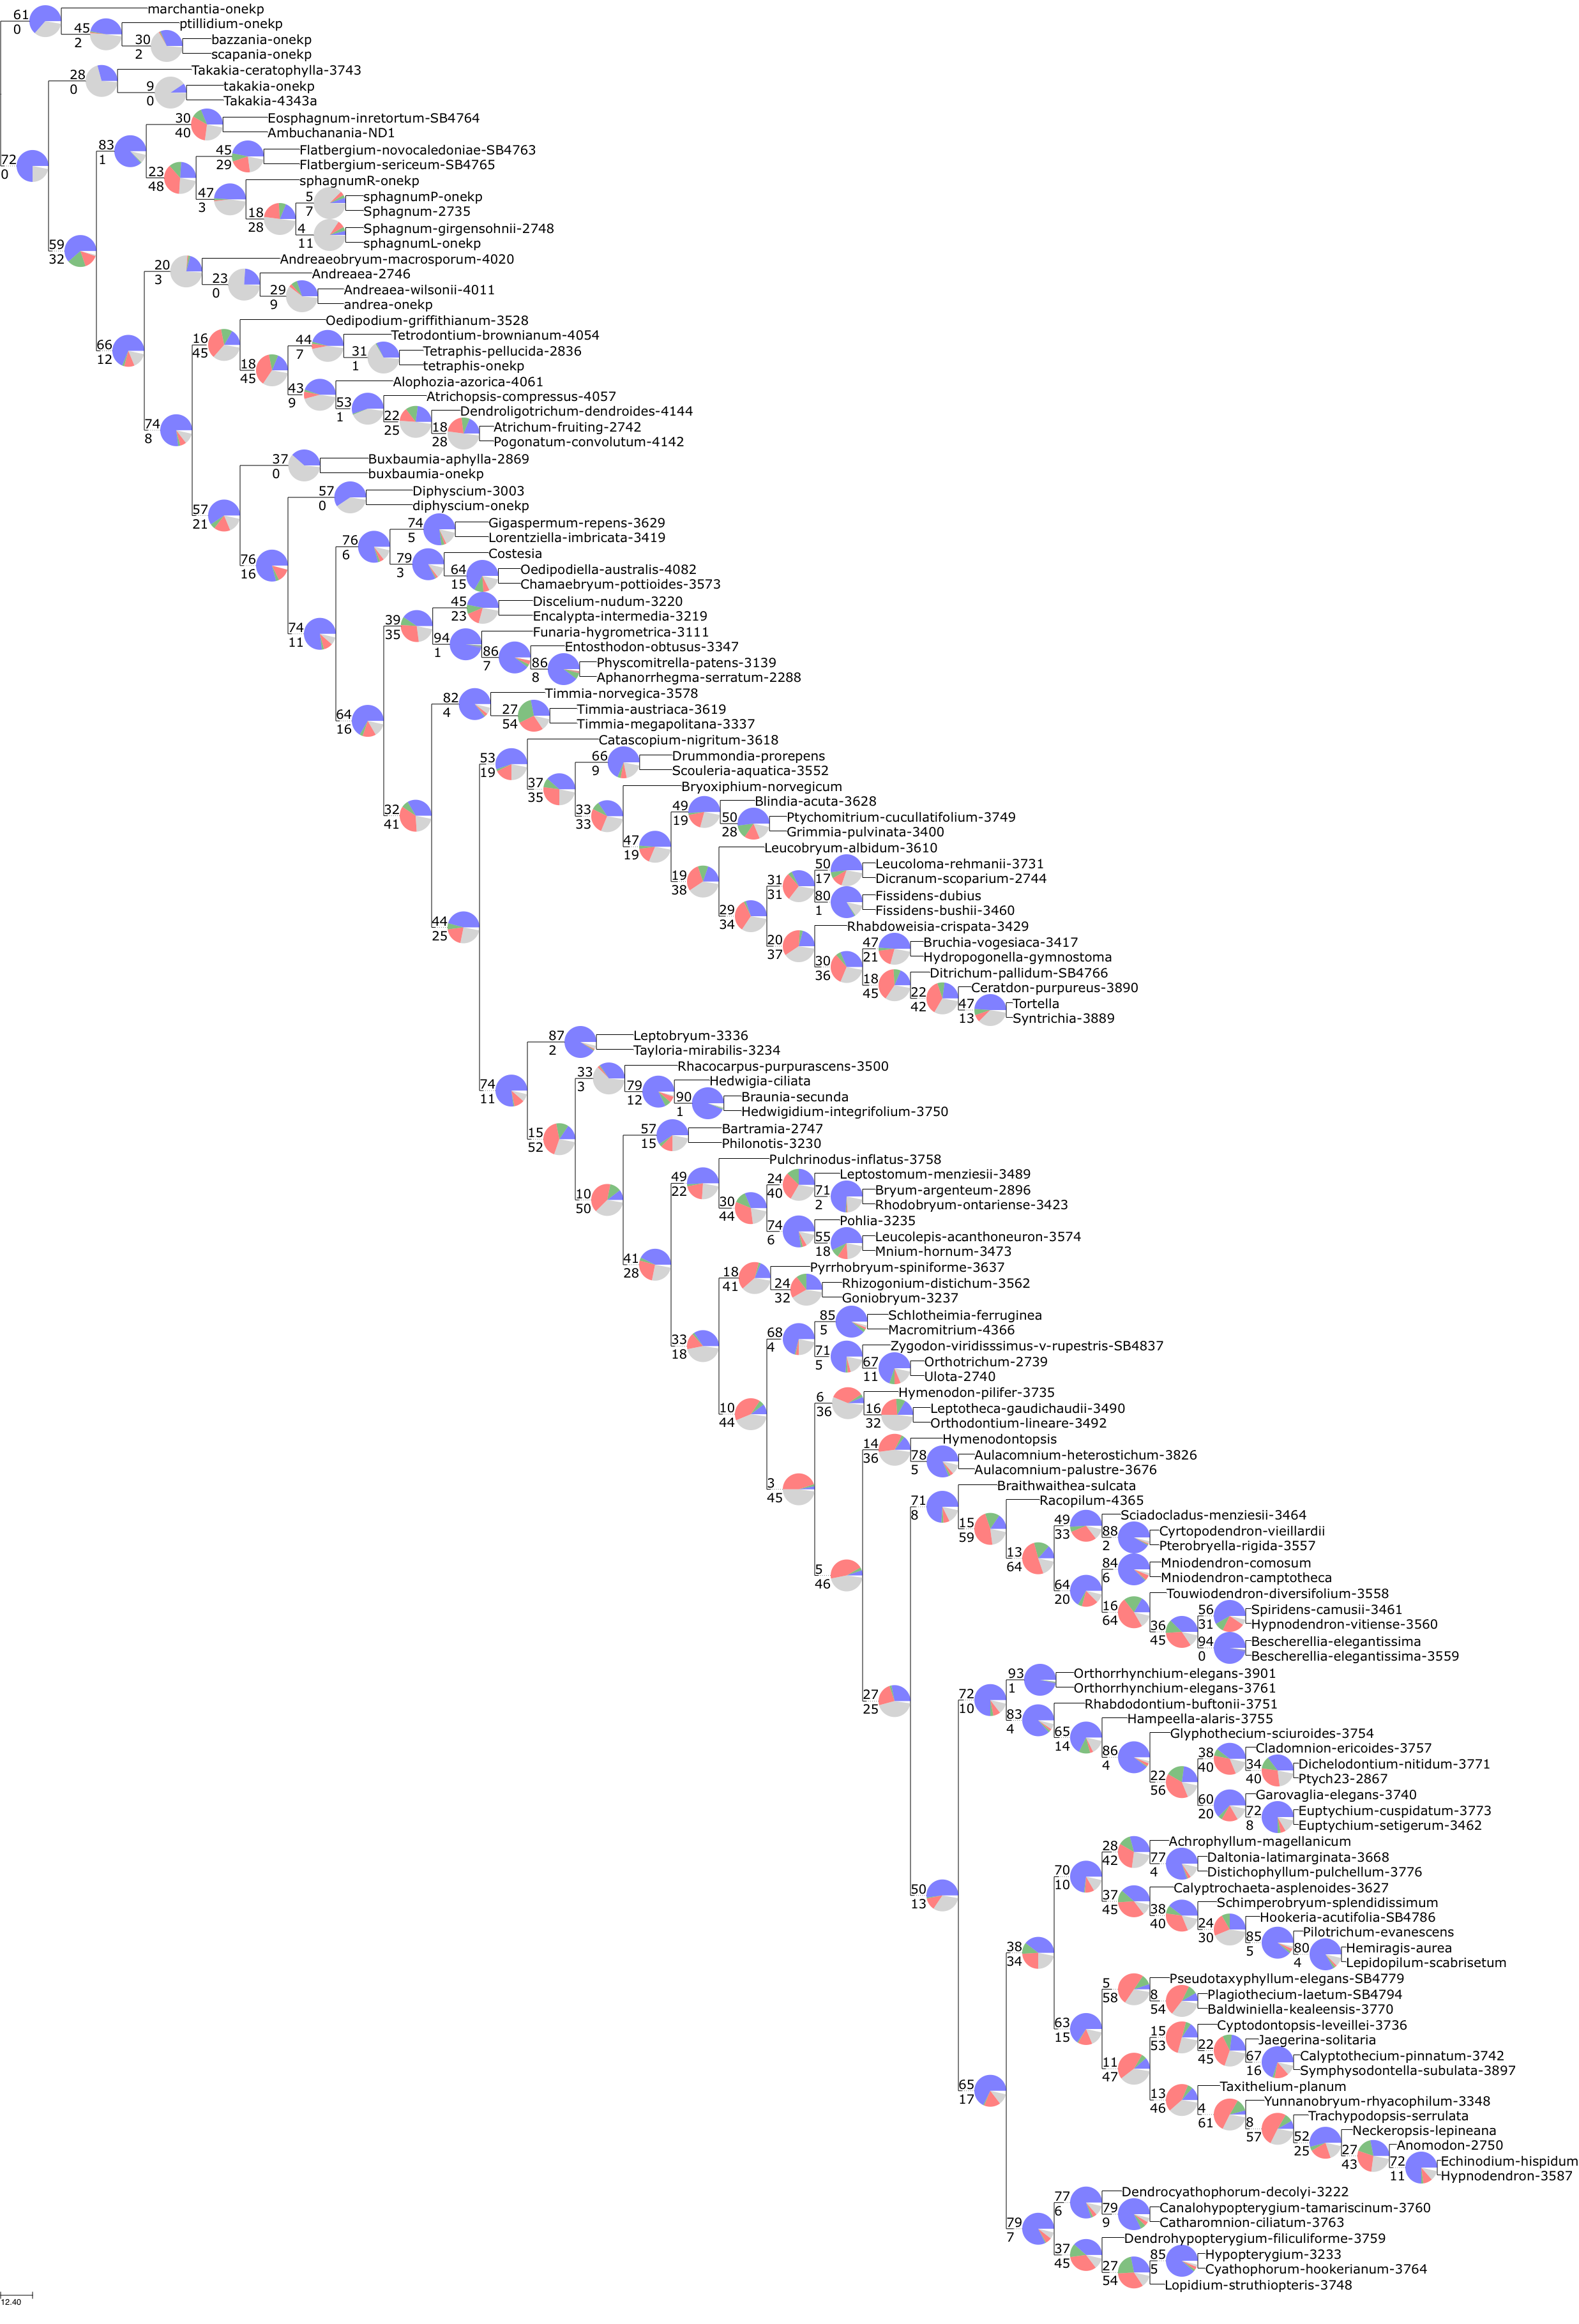

In [7]:
plot_tree = sptree

def phyparts_pie_layout(mynode):
    if mynode.name in phyparts_pies:
        pie= faces.PieChartFace(phyparts_pies[mynode.name],
                              #colors=COLOR_SCHEMES["set1"],
                              colors = ["blue","green","red","dark gray"],
                              width=50, height=50)
        pie.border.width = None
        pie.opacity = 0.5
        faces.add_face_to_node(pie,mynode, 0, position="branch-right")
        
        concord_text = faces.TextFace(int(concord_dict[mynode.name]),fsize=20)
        conflict_text = faces.TextFace(int(conflict_dict[mynode.name]),fsize=20)
        
        faces.add_face_to_node(concord_text,mynode,0,position = "branch-top")
        faces.add_face_to_node(conflict_text,mynode,1,position="branch-bottom")
        
        
    else:
        F = faces.TextFace(mynode.name,fsize=20)
        faces.add_face_to_node(F,mynode,0,position="branch-right")


ts = TreeStyle()
ts.show_leaf_name = False
        
ts.layout_fn = phyparts_pie_layout
ts.mode = "r"
nstyle = NodeStyle()
nstyle["size"] = 0
for n in plot_tree.traverse():
    n.set_style(nstyle)
    n.img_style["vt_line_width"] = 0

    
plot_tree.convert_to_ultrametric()    
#my_svg = plot_tree.render("astral_withpies_fromconcontre.svg",tree_style=ts,w=595) 
plot_tree.render("%%inline",tree_style=ts)

Also show the node numbers as defined by Phyparts, for reference.

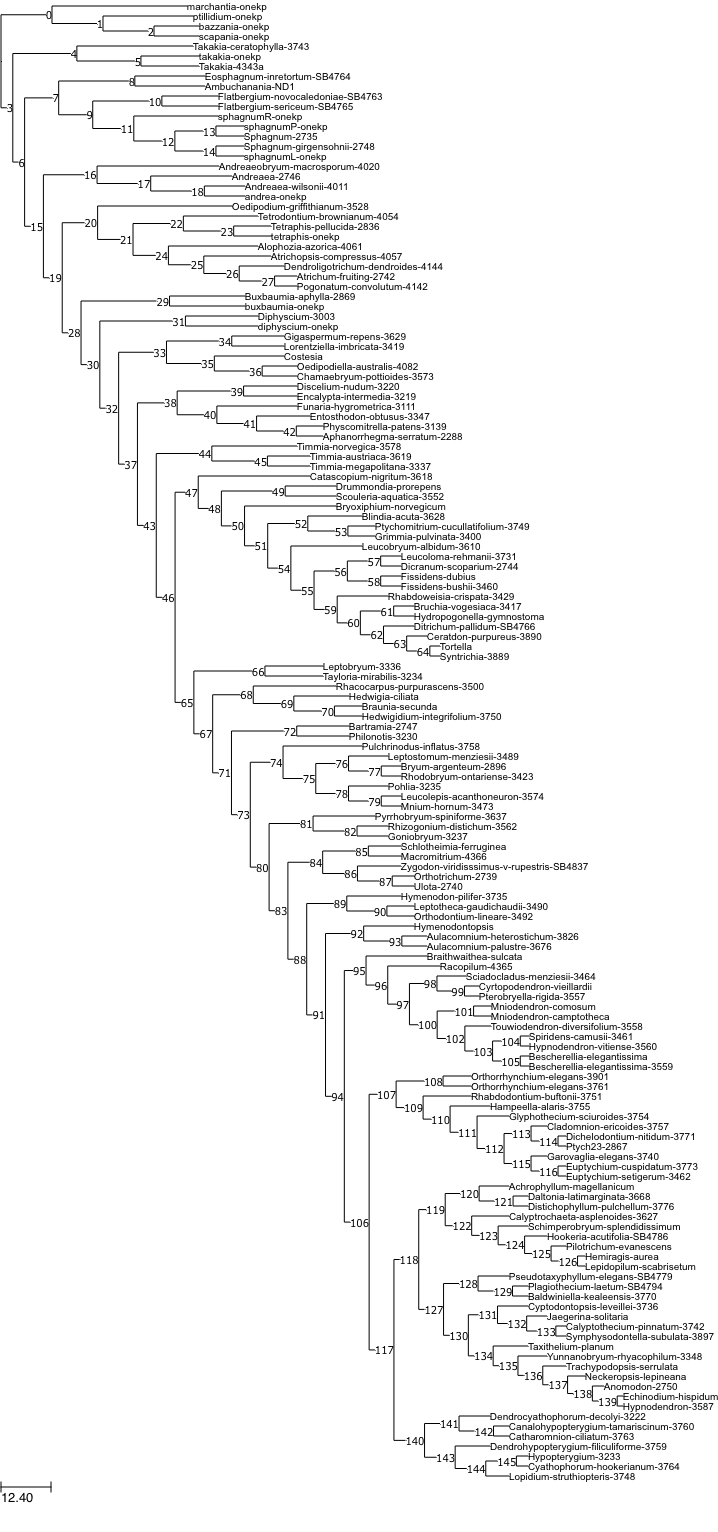

In [8]:
def node_name(node):
    if not node.is_leaf():
        F = TextFace(node.name)
        faces.add_face_to_node(F,node,0,"branch-top")
    
nstyle = NodeStyle()
nstyle["size"] = 0
for n in sptree.traverse():
    n.set_style(nstyle)
    #n.img_style["vt_line_width"] = 1

sptree.convert_to_ultrametric()    
ts = TreeStyle()
ts.layout_fn = node_name
ts.mode="r"
ts.show_leaf_name = True        
#Make the tips sorta line up...


sptree.render("%%inline",tree_style=ts)
